## Depth integrated tracer on shelf per km along shelf

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [4]:
# plotting functions
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')


In [25]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)

PtracersCNT = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc' 

PtracersCNTNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc' 


In [6]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')

labels = ['Linear','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Acid','Methane']

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [7]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [26]:
Lin = rout.getField(PtracersCNT, 'Tr1')
LinNoC = rout.getField(PtracersCNTNoC, 'Tr1')

# salinity is the profile for tracer 2 but I won't be using it

Oxy = rout.getField(Ptracers, 'Tr03')
OxyNoC = rout.getField(PtracersNoC, 'Tr03')

Nit = rout.getField(Ptracers, 'Tr04')
NitNoC = rout.getField(PtracersNoC, 'Tr04')


In [9]:
Sil = rout.getField(Ptracers, 'Tr05')
SilNoC = rout.getField(PtracersNoC, 'Tr05')

Pho = rout.getField(Ptracers, 'Tr06')
PhoNoC = rout.getField(PtracersNoC, 'Tr06')

NAc = rout.getField(Ptracers, 'Tr07')
NAcNoC = rout.getField(PtracersNoC, 'Tr07')

Met = rout.getField(Ptracers, 'Tr08')
MetNoC = rout.getField(PtracersNoC, 'Tr08')



## Bakley tracers - canyon 

In [27]:
HCWLin,TrMassLin = HCW_Tracer_AlongShelf(Lin,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWLinNoC,TrMassLinNoC = HCW_Tracer_AlongShelf(LinNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWOxy,TrMassOxy = HCW_Tracer_AlongShelf(Oxy,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWOxyNoC,TrMassOxyNoC = HCW_Tracer_AlongShelf(OxyNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWNit,TrMassNit = HCW_Tracer_AlongShelf(Nit,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWNitNoC,TrMassNitNoC = HCW_Tracer_AlongShelf(NitNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWSil,TrMassSil = HCW_Tracer_AlongShelf(Sil,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWSilNoC,TrMassSilNoC = HCW_Tracer_AlongShelf(SilNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWPho,TrMassPho = HCW_Tracer_AlongShelf(Pho,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWPhoNoC,TrMassPhoNoC = HCW_Tracer_AlongShelf(PhoNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWNAc,TrMassNAc = HCW_Tracer_AlongShelf(NAc,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWNAcNoC,TrMassNAcNoC = HCW_Tracer_AlongShelf(NAcNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWMet,TrMassMet = HCW_Tracer_AlongShelf(Met,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWMetNoC,TrMassMetNoC = HCW_Tracer_AlongShelf(MetNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 103.13976)
('tracer limit concentration is: ', 103.13976)
('tracer limit concentration is: ', 32.763577)
('tracer limit concentration is: ', 32.763577)
('tracer limit concentration is: ', 47.862217)
('tracer limit concentration is: ', 47.862217)
('tracer limit concentration is: ', 2.2521822)
('tracer limit concentration is: ', 2.2521822)
('tracer limit concentration is: ', 27.700876)
('tracer limit concentration is: ', 27.700876)
('tracer limit concentration is: ', 19.381783)
('tracer limit concentration is: ', 19.381783)


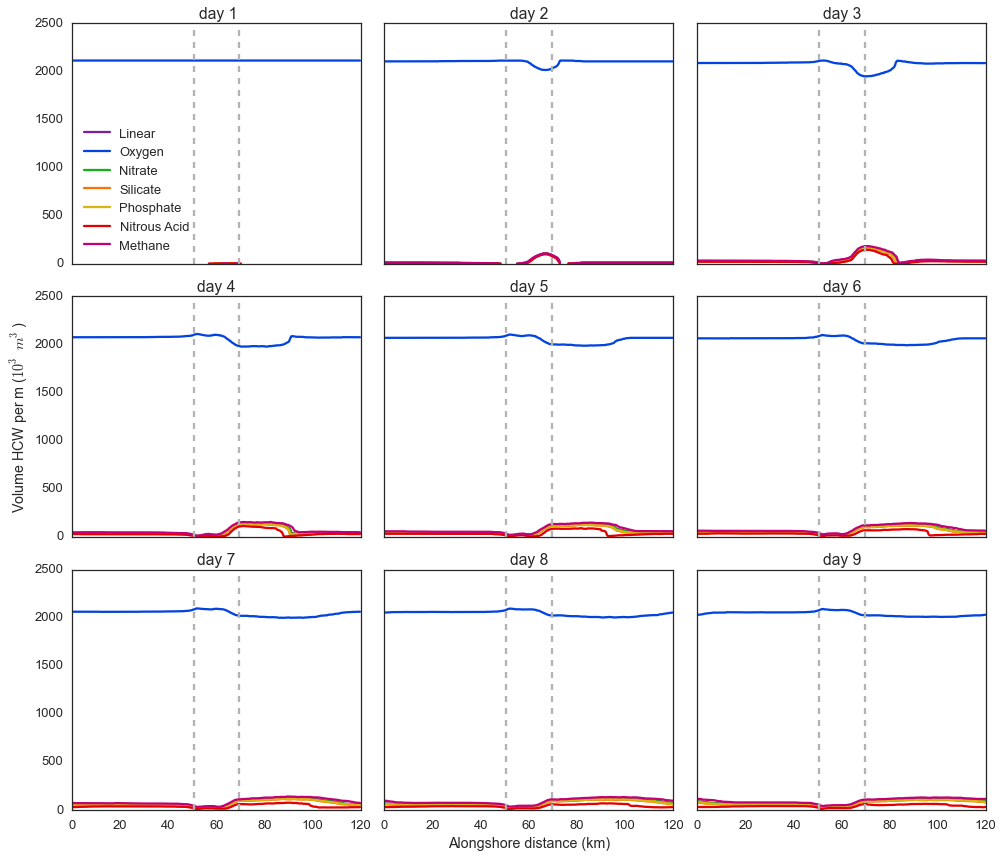

In [28]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,HCWLin[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["purple"],label=labels[0])
    ax.plot(xc[1,:]/1000,HCWOxy[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["blue"],label=labels[1])
    ax.plot(xc[1,:]/1000,HCWNit[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["green"],label=labels[2])
    ax.plot(xc[1,:]/1000,HCWSil[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["orange"],label=labels[3])
    ax.plot(xc[1,:]/1000,HCWPho[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["gold"],label=labels[4])
    ax.plot(xc[1,:]/1000,HCWNAc[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["red"],label=labels[5])
    ax.plot(xc[1,:]/1000,HCWMet[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["magenta"],label=labels[6])
    
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')

    
plt.tight_layout()

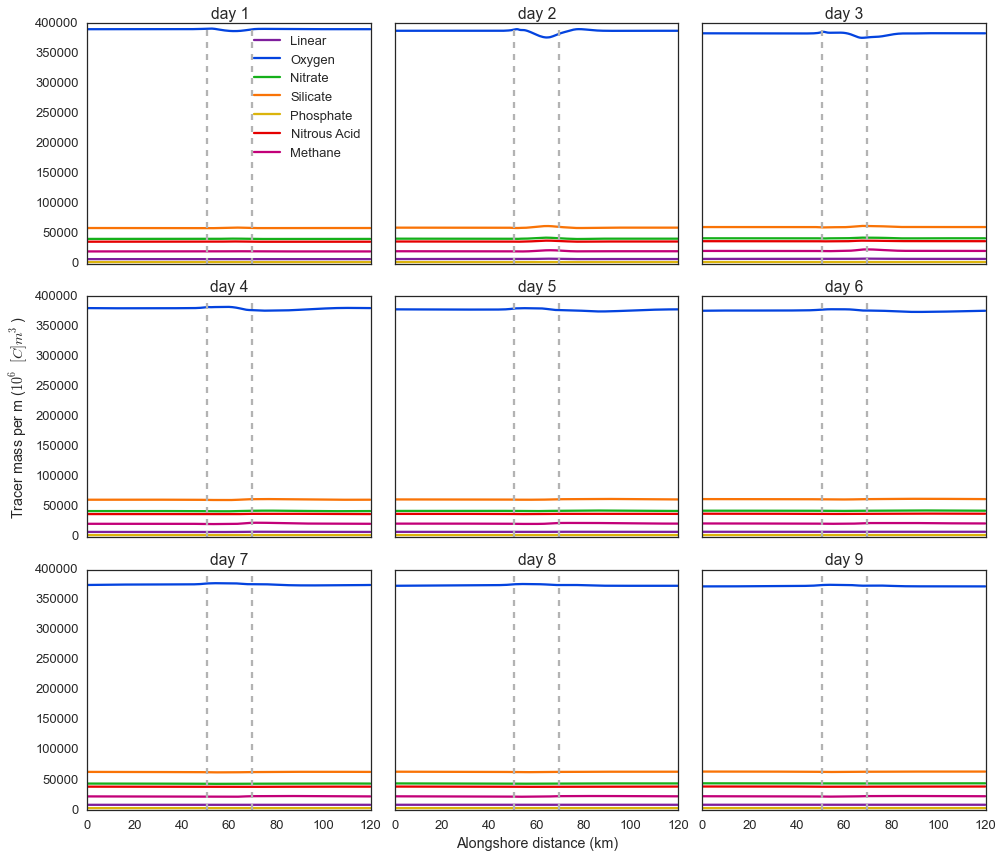

In [29]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,TrMassLin[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["purple"],label=labels[0])
    ax.plot(xc[1,:]/1000,TrMassOxy[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["blue"],label=labels[1])
    ax.plot(xc[1,:]/1000,TrMassNit[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["green"],label=labels[2])
    ax.plot(xc[1,:]/1000,TrMassSil[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["orange"],label=labels[3])
    ax.plot(xc[1,:]/1000,TrMassPho[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["gold"],label=labels[4])
    ax.plot(xc[1,:]/1000,TrMassNAc[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["red"],label=labels[5])
    ax.plot(xc[1,:]/1000,TrMassMet[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["magenta"],label=labels[6])
    
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')

plt.tight_layout()    


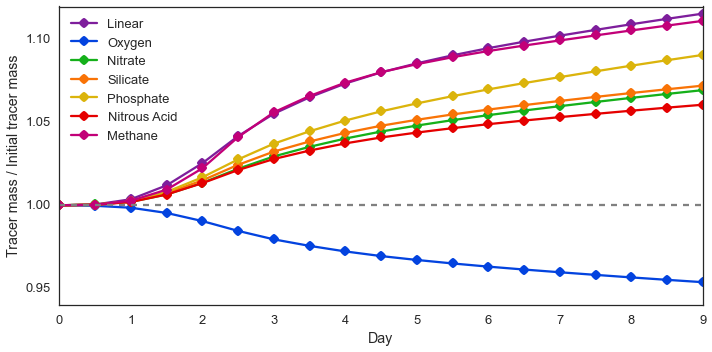

In [34]:
fig,(ax1) = plt.subplots(1,1, figsize = (10,5),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.0,np.sum(TrMassLin,axis=1)/np.sum(TrMassLin,axis=1)[0],
         sns.xkcd_rgb["purple"],
         marker = 'o',
         label=labels[0])
ax1.plot(tt/2.0,np.sum(TrMassOxy,axis=1)/np.sum(TrMassOxy,axis=1)[0],
         sns.xkcd_rgb["blue"],
         marker = 'o',
         label=labels[1])
ax1.plot(tt/2.0,np.sum(TrMassNit,axis=1)/np.sum(TrMassNit,axis=1)[0],
         sns.xkcd_rgb["green"],
         marker = 'o',
         label=labels[2])
ax1.plot(tt/2.0,np.sum(TrMassSil,axis=1)/np.sum(TrMassSil,axis=1)[0],
         sns.xkcd_rgb["orange"],
         marker = 'o',
         label=labels[3])
ax1.plot(tt/2.0,np.sum(TrMassPho,axis=1)/np.sum(TrMassPho,axis=1)[0],
         sns.xkcd_rgb["gold"],
         marker = 'o',
         label=labels[4])
ax1.plot(tt/2.0,np.sum(TrMassNAc,axis=1)/np.sum(TrMassNAc,axis=1)[0],
         sns.xkcd_rgb["red"],
         marker = 'o',
         label=labels[5])
ax1.plot(tt/2.0,np.sum(TrMassMet,axis=1)/np.sum(TrMassMet,axis=1)[0],
         sns.xkcd_rgb["magenta"],
         marker = 'o',
         label=labels[6])
    

ax1.axhline(1.0,linestyle ='--',color='0.5')      
ax1.legend(loc=0)
ax1.set_xlabel('Day')
ax1.set_ylabel('Tracer mass / Initial tracer mass')
plt.tight_layout()

plt.show()



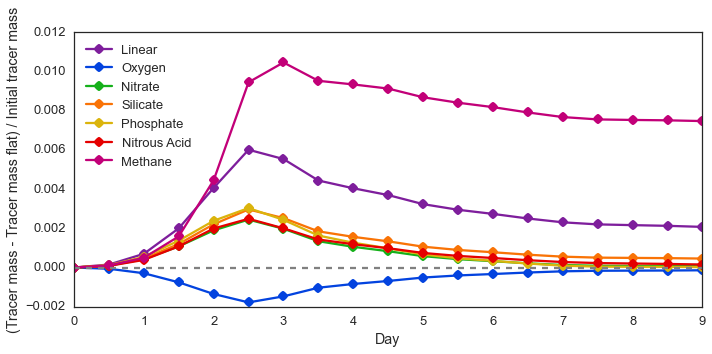

In [37]:
fig,(ax1) = plt.subplots(1,1, figsize = (10,5),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.0,(np.sum(TrMassLin,axis=1)-np.sum(TrMassLinNoC,axis=1))/np.sum(TrMassLin,axis=1)[0],
         sns.xkcd_rgb["purple"],
         marker = 'o',
         label=labels[0])
ax1.plot(tt/2.0,(np.sum(TrMassOxy,axis=1)-np.sum(TrMassOxyNoC,axis=1))/np.sum(TrMassOxy,axis=1)[0],
         sns.xkcd_rgb["blue"],
         marker = 'o',
         label=labels[1])
ax1.plot(tt/2.0,(np.sum(TrMassNit,axis=1)-np.sum(TrMassNitNoC,axis=1))/np.sum(TrMassNit,axis=1)[0],
         sns.xkcd_rgb["green"],
         marker = 'o',
         label=labels[2])
ax1.plot(tt/2.0,(np.sum(TrMassSil,axis=1)-np.sum(TrMassSilNoC,axis=1))/np.sum(TrMassSil,axis=1)[0],
         sns.xkcd_rgb["orange"],
         marker = 'o',
         label=labels[3])
ax1.plot(tt/2.0,(np.sum(TrMassPho,axis=1)-np.sum(TrMassPhoNoC,axis=1))/np.sum(TrMassPho,axis=1)[0],
         sns.xkcd_rgb["gold"],
         marker = 'o',
         label=labels[4])
ax1.plot(tt/2.0,(np.sum(TrMassNAc,axis=1)-np.sum(TrMassNAcNoC,axis=1))/np.sum(TrMassNAc,axis=1)[0],
         sns.xkcd_rgb["red"],
         marker = 'o',
         label=labels[5])
ax1.plot(tt/2.0,(np.sum(TrMassMet,axis=1)-np.sum(TrMassMetNoC,axis=1))/np.sum(TrMassMet,axis=1)[0],
         sns.xkcd_rgb["magenta"],
         marker = 'o',
         label=labels[6])
    

ax1.axhline(0.0,linestyle ='--',color='0.5')      
ax1.legend(loc=0)
ax1.set_xlabel('Day')
ax1.set_ylabel('(Tracer mass - Tracer mass flat) / Initial tracer mass')
plt.tight_layout()

plt.show()

